In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tf_explain.core.grad_cam import GradCAM
import os
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tf_explain.core.grad_cam import GradCAM
import os
import random
import os
import uuid
import random
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
import os
import PIL
import cv2
import uuid
import shutil
import random
import glob as gb
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from tqdm import tqdm  # Progress bar
from scipy.special import gamma

from keras.optimizers import *
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv2D, MaxPool2D, BatchNormalization

from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [34]:
calc_train = pd.read_csv(r'C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')
calc_test = pd.read_csv(r'C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_test_set.csv')
mass_train = pd.read_csv(r'C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv(r'C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')
dicom_df = pd.read_csv(r'C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')

In [35]:
cropped_images = dicom_df[dicom_df.SeriesDescription=="cropped images"].image_path
full_mammogram = dicom_df[dicom_df.SeriesDescription=="full mammogram images"].image_path
roi_mask = dicom_df[dicom_df.SeriesDescription=="ROI mask images"].image_path

cropped_images

0        CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3        CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6        CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7        CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10       CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
                               ...                        
10225    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.374221...
10227    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.195242...
10229    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.263713...
10231    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.627982...
10236    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.285138...
Name: image_path, Length: 3567, dtype: object

In [36]:
def replace_path(sample, old_path, new_path):
    return sample.replace(old_path, new_path, regex=True)

# Replace the path for cropped_images to the correct directory.
correct_dir = r"C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg"
cropped_images = replace_path(cropped_images, "CBIS-DDSM/jpeg", correct_dir)
print('Cropped Images paths:')
print(cropped_images.iloc[0])

# Replace the path for full_mammogram images to the correct directory.
full_mammogram = replace_path(full_mammogram, "CBIS-DDSM/jpeg", correct_dir)
print('\nFull mammo Images paths:')
print(full_mammogram.iloc[0]) 

# Replace the path for roi_mask images to the correct directory.
roi_mask = replace_path(roi_mask, "CBIS-DDSM/jpeg", correct_dir)
print('\nROI Mask Images paths:')
print(roi_mask.iloc[0])

Cropped Images paths:
C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg

Full mammo Images paths:
C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg

ROI Mask Images paths:
C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [37]:
def get_image_file_name(data, new_dict):
    for dicom in data:
        key = dicom.split('/')[12]
        new_dict[key] = dicom
    print(f"the length of dataset : {len(new_dict.keys())}")

cropped_images_dict = dict()
full_mammo_dict = dict()
roi_img_dict = dict()

get_image_file_name(cropped_images, cropped_images_dict)
get_image_file_name(full_mammogram, full_mammo_dict)
get_image_file_name(roi_mask, roi_img_dict)

the length of dataset : 3567
the length of dataset : 2857
the length of dataset : 3247


In [38]:
mass_train

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313,P_02033,2,RIGHT,MLO,1,mass,IRREGULAR,ILL_DEFINED,3,MALIGNANT,4,Mass-Training_P_02033_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_02033_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_02033_RIGHT_MLO_1/1.3.6.1.4.1....
1314,P_02079,2,RIGHT,CC,1,mass,ROUND,SPICULATED,3,MALIGNANT,5,Mass-Training_P_02079_RIGHT_CC/1.3.6.1.4.1.959...,Mass-Training_P_02079_RIGHT_CC_1/1.3.6.1.4.1.9...,Mass-Training_P_02079_RIGHT_CC_1/1.3.6.1.4.1.9...
1315,P_02079,2,RIGHT,MLO,1,mass,ROUND,SPICULATED,3,MALIGNANT,5,Mass-Training_P_02079_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_02079_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_02079_RIGHT_MLO_1/1.3.6.1.4.1....
1316,P_02092,2,LEFT,CC,1,mass,IRREGULAR,SPICULATED,3,MALIGNANT,2,Mass-Training_P_02092_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_02092_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_02092_LEFT_CC_1/1.3.6.1.4.1.95...


In [39]:
def fix_image_path(data):
    """Correct dicom paths to correct image paths."""
    for indx, image in enumerate(data.values):
        img_name = image[11].split('/')[2]

        if img_name in full_mammo_dict:
            data.iloc[indx, 11] = full_mammo_dict[img_name]
        else:
            data.iloc[indx, 11] = None
        
        img_name = image[12].split('/')[2]
        if img_name in cropped_images_dict:
            data.iloc[indx, 12] = cropped_images_dict[img_name]
        else:
            data.iloc[indx, 11] = None

        img_name = image[13].split('/')[2]
        if img_name in roi_img_dict:
            data.iloc[indx, 13] = roi_img_dict[img_name]

        else:
            data.iloc[indx, 13] = None

fix_image_path(mass_train)

mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
mass_train.head(5)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...


In [40]:
mass_train.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [41]:
fix_image_path(mass_test)

mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                      'image view': 'image_view',
                                      'abnormality id': 'abnormality_id',
                                      'abnormality type': 'abnormality_type',
                                      'mass shape': 'mass_shape',
                                      'mass margins': 'mass_margins',
                                      'image file path': 'image_file_path',
                                      'cropped image file path': 'cropped_image_file_path',
                                      'ROI mask file path': 'ROI_mask_file_path'})
# view renamed columns
mass_test.head()

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...


In [42]:
calc_train = calc_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
# view renamed columns
calc_train.head()

fix_image_path(calc_train)

In [43]:
calc_test = calc_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                      'image view': 'image_view',
                                      'abnormality id': 'abnormality_id',
                                      'abnormality type': 'abnormality_type',
                                      'mass shape': 'mass_shape',
                                      'mass margins': 'mass_margins',
                                      'image file path': 'image_file_path',
                                      'cropped image file path': 'cropped_image_file_path',
                                      'ROI mask file path': 'ROI_mask_file_path'})
# view renamed columns
calc_test.head()

fix_image_path(calc_test)

In [55]:
def display_images(dataset, column, number):
    """Displays images in dataset, handling missing files and converting formats."""
    
    # create figure and axes
    fig, axes = plt.subplots(1, number, figsize=(15, 5))
    
    # Loop through rows and display images
    for index, (i, row) in enumerate(dataset.head(number).iterrows()):
        image_path = row[column]
        
       # Check if image_path is valid (not None) and exists
        if image_path is None or not os.path.exists(image_path):
            # print(f"File not found or invalid path: {image_path}")
            continue
        image = cv2.imread(image_path)
        
        # Handle case when image can't be read
        if image is None:
            # print(f"Error reading image: {image_path}")
            continue
        
        # Convert BGR to RGB if needed (for correct color display)
        if len(image.shape) == 3 and image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ax = axes[index]
        ax.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        ax.set_title(f"{row['pathology']}")
        ax.axis('off')
        print("Shape:", np.array(image).shape)
    
    plt.tight_layout()
    plt.show()



Full Mammograms:

Shape: (4808, 3024, 3)
Shape: (4800, 2656, 3)
Shape: (5491, 2986, 3)
Shape: (5491, 3046, 3)
Shape: (5491, 2911, 3)


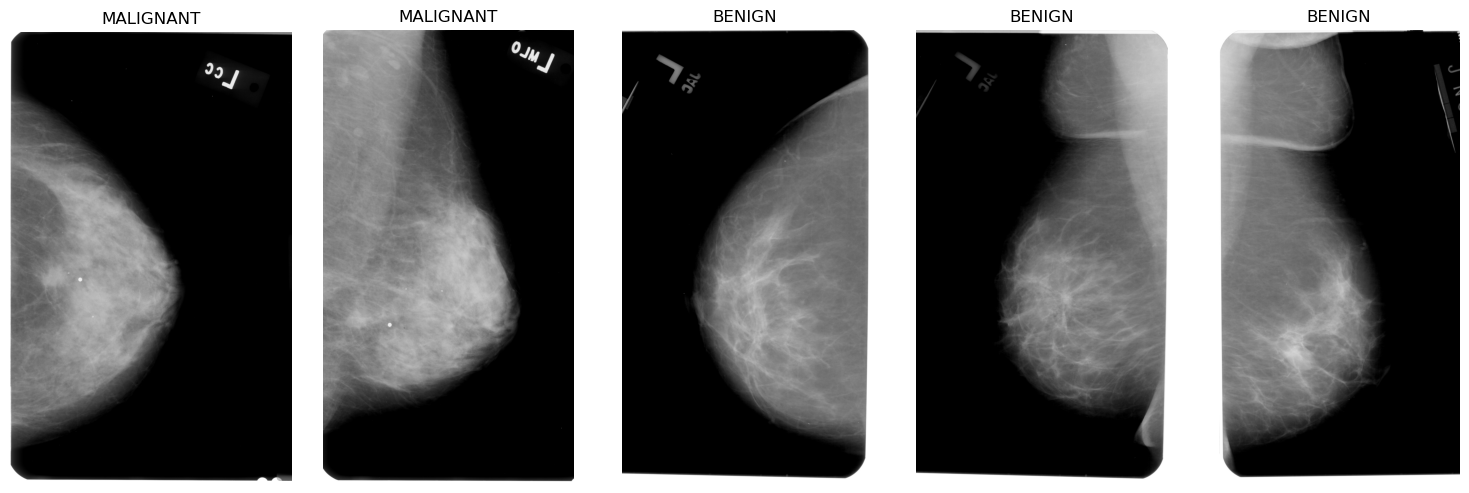

Cropped Mammograms:

Shape: (515, 431, 3)
Shape: (292, 256, 3)
Shape: (466, 423, 3)
Shape: (427, 422, 3)
Shape: (399, 465, 3)


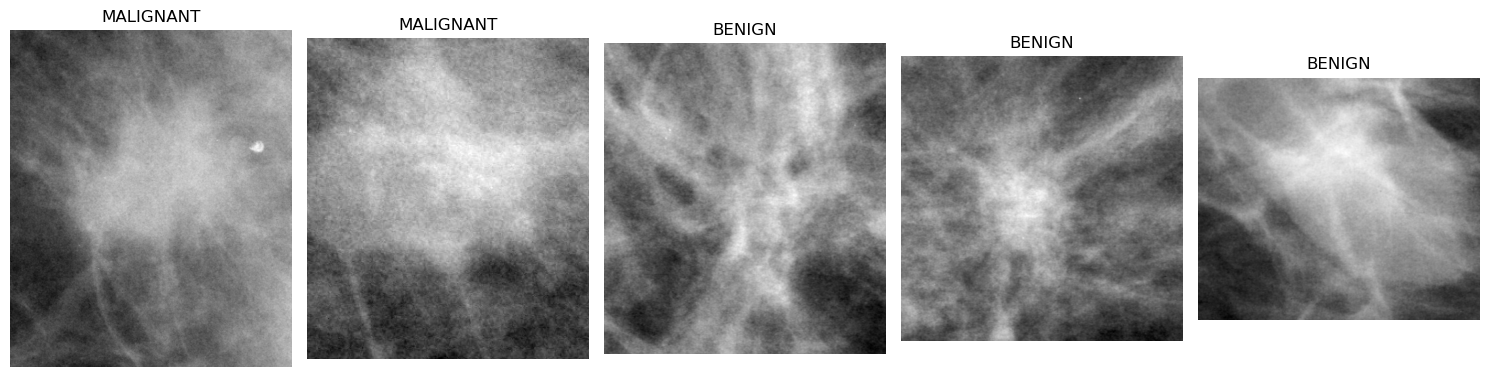

ROI_mask:

Shape: (4808, 3024, 3)
Shape: (4800, 2656, 3)
Shape: (5491, 2986, 3)
Shape: (5491, 3046, 3)
Shape: (5491, 2911, 3)


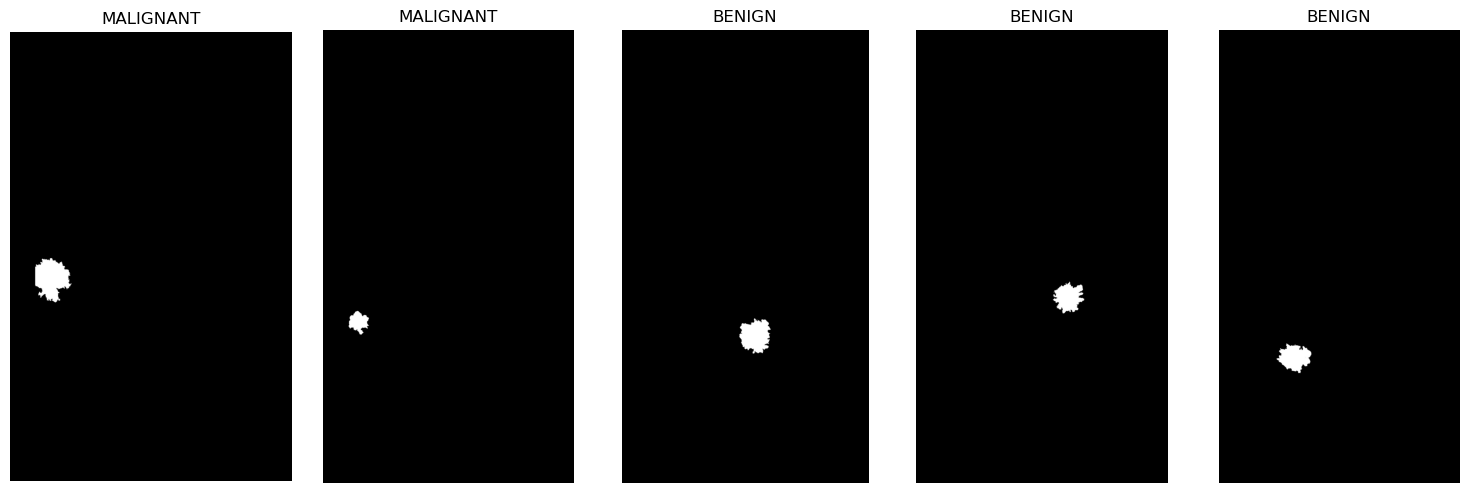

In [49]:
print('Full Mammograms:\n')
display_images(mass_train, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(mass_train, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(mass_train, 'ROI_mask_file_path', 5)

Full Mammograms:

(4006, 1846, 3)
(5491, 2011, 3)
(5904, 3200, 3)
(5952, 3352, 3)
(5116, 2641, 3)


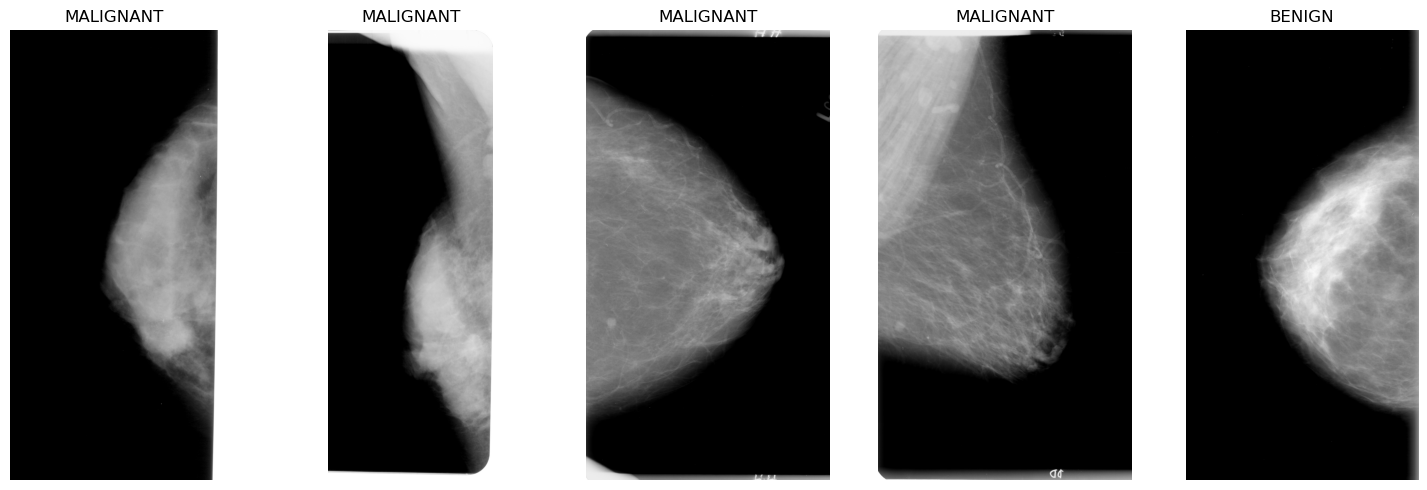

Cropped Mammograms:

(384, 385, 3)
(369, 328, 3)
(214, 195, 3)
(220, 225, 3)
(405, 376, 3)


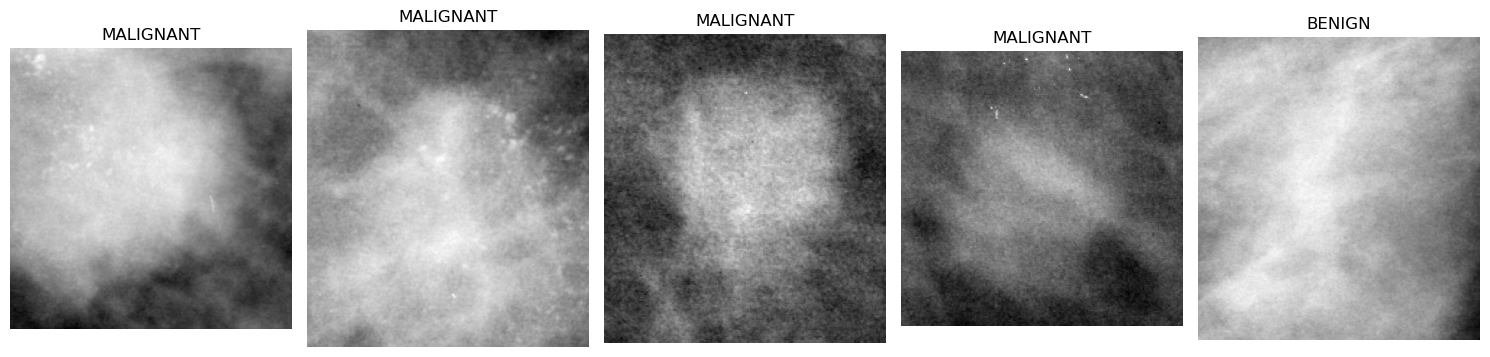

ROI_mask:

(4006, 1846, 3)
(5491, 2011, 3)
(5904, 3200, 3)
(5952, 3352, 3)
(5116, 2641, 3)


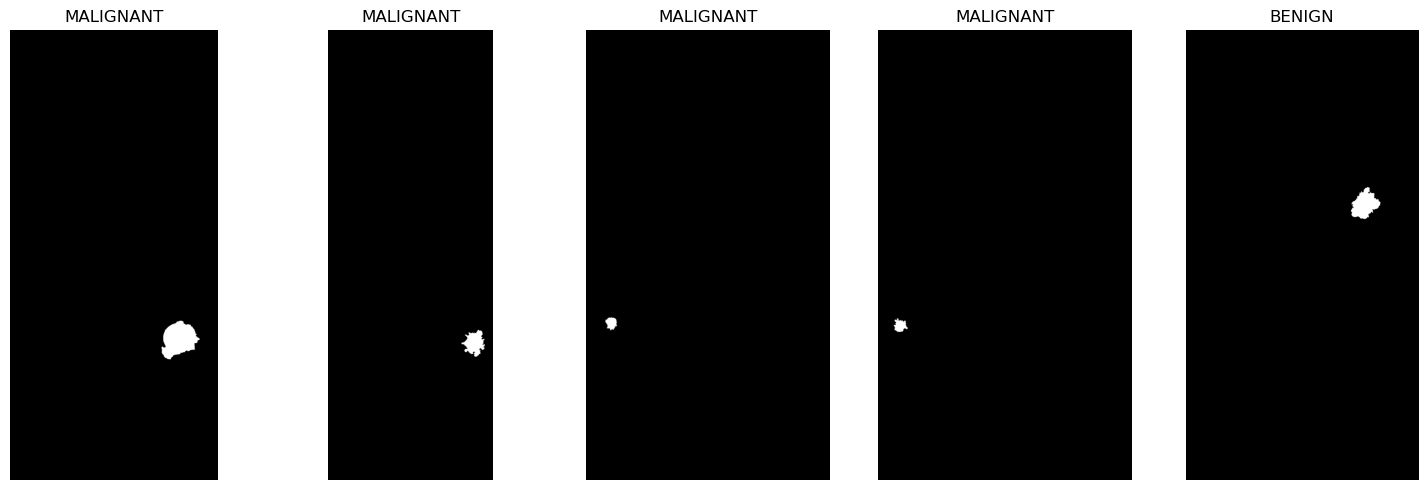

In [45]:
print('Full Mammograms:\n')
display_images(mass_test, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(mass_test, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(mass_test, 'ROI_mask_file_path', 5)

Full Mammograms:

Shape: (5056, 2761, 3)
Shape: (5386, 2836, 3)
Shape: (5356, 2986, 3)
Shape: (5491, 3166, 3)
Shape: (4568, 3064, 3)


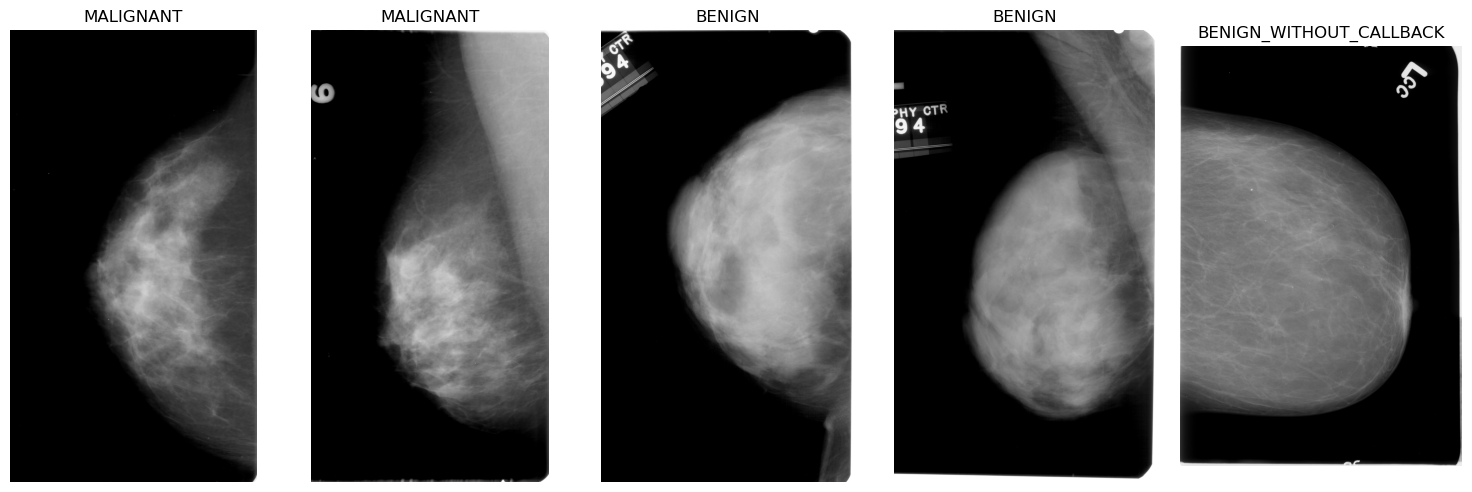

Cropped Mammograms:

Shape: (589, 677, 3)
Shape: (549, 681, 3)
Shape: (681, 577, 3)
Shape: (689, 761, 3)
Shape: (161, 177, 3)


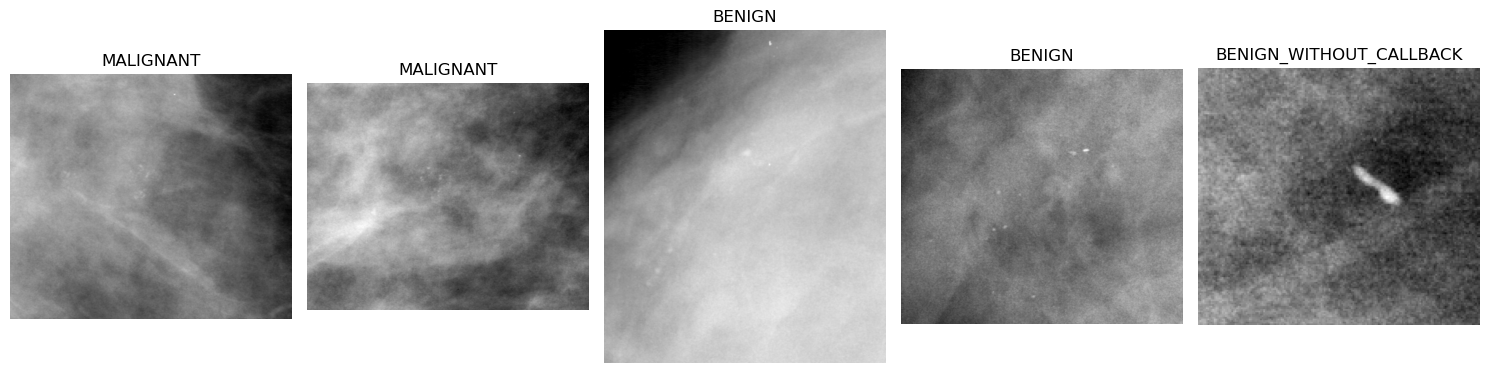

ROI_mask:

Shape: (5056, 2761, 3)
Shape: (5386, 2836, 3)
Shape: (5356, 2986, 3)
Shape: (5491, 3166, 3)
Shape: (4568, 3064, 3)


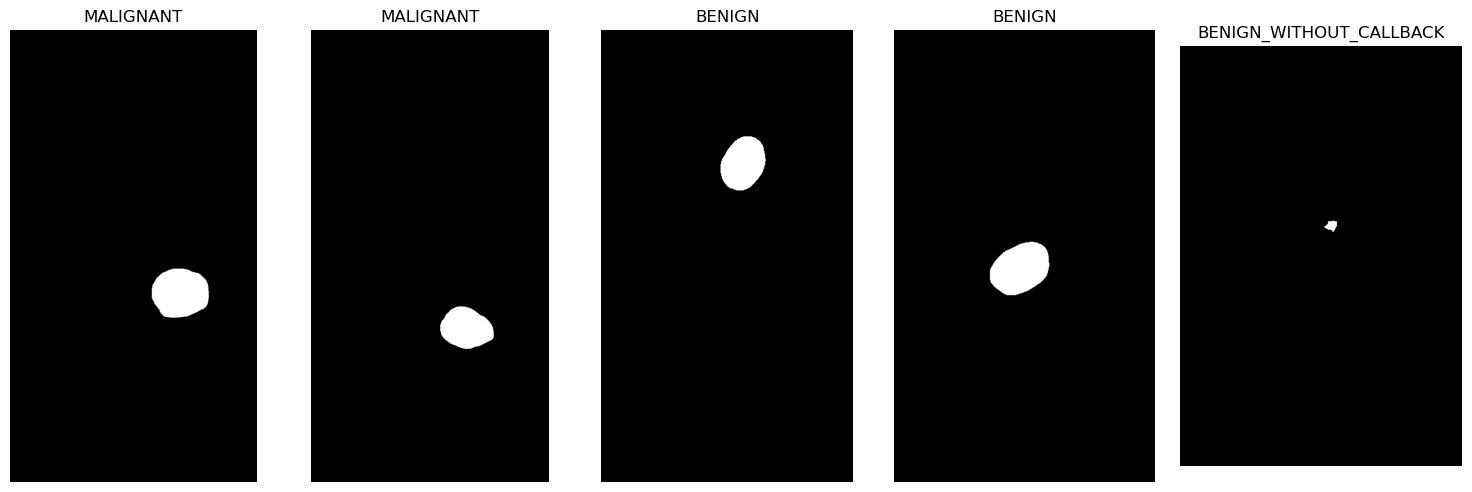

In [52]:
print('Full Mammograms:\n')
display_images(calc_train, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(calc_train, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(calc_train, 'ROI_mask_file_path', 5)

Cropped Mammograms:

Shape: (249, 265, 3)
Shape: (265, 249, 3)
Shape: (409, 660, 3)
Shape: (257, 724, 3)
Shape: (809, 833, 3)


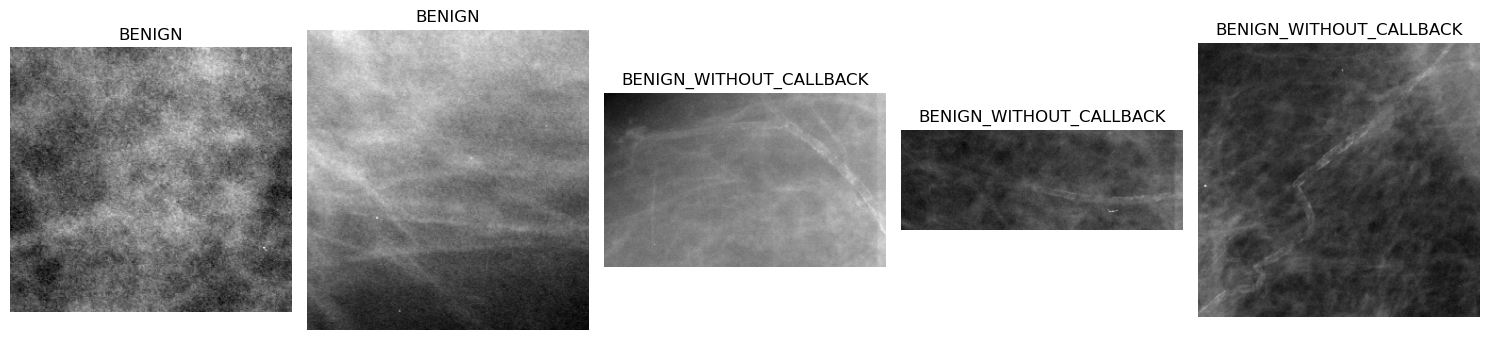

In [51]:
print('Cropped Mammograms:\n')
display_images(calc_test, 'cropped_image_file_path', 5)

In [56]:
full_dataset = pd.concat([calc_train, calc_test], axis=0)
len(full_dataset)

1872

In [58]:
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0} 
target_size = (224, 224, 3)

# Apply class mapper to pathology column
full_dataset['labels'] = full_dataset['pathology'].replace(class_mapper).infer_objects(copy=False)

full_images = np.array(full_dataset[full_dataset["image_file_path"].notna()]["image_file_path"].tolist())
full_labels = np.array(full_dataset[full_dataset["image_file_path"].notna()]["labels"].tolist())

# If full_labels is a NumPy array, convert it to a Pandas series
full_labels_series = pd.Series(full_labels)

# Count the occurrences of each class
label_counts = full_labels_series.value_counts()

# Assuming 0 = benign and 1 = malignant
benign_count = label_counts.get(0, 0)
malignant_count = label_counts.get(1, 0)

print(f"Benign images: {benign_count}")
print(f"Malignant images: {malignant_count}")

Benign images: 1018
Malignant images: 570


C:\Users\Anne\AppData\Local\Temp\ipykernel_18632\1228075069.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_dataset['labels'] = full_dataset['pathology'].replace(class_mapper).infer_objects(copy=False)


In [59]:
num_classes = len(full_dataset['labels'].unique())
num_classes

2

In [60]:
class_names = ['Benign', 'Malignant']

In [61]:
# Check the distribution of labels
label_counts = full_dataset['labels'].value_counts()
print(label_counts)

labels
0    1199
1     673
Name: count, dtype: int64


In [ ]:
# # Define a function for data augmentation
# def augment_image(image):
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_brightness(image, max_delta=0.3)
#     image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
#     image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
#     return image

# # Function to resize image to (224, 224, 3)
# def resize_image(image_tensor):
#     return tf.image.resize(image_tensor, [224, 224])

# # Function to balance classes by augmenting images
# def copy_images_with_unique_filenames(images, labels, source, destination, target_count=None):
#     """
#     Copy images from source to destination in subfolders '0' and '1',
#     ensuring unique filenames and applying data augmentation and balancing.
#     """
#     benign_images = 0
#     malignant_images = 0
#     skipped_images = []

#     # Create the destination subfolders '0' and '1'
#     category_dest_dir_zero = os.path.join(destination, '0')
#     os.makedirs(category_dest_dir_zero, exist_ok=True)

#     category_dest_dir_one = os.path.join(destination, '1')
#     os.makedirs(category_dest_dir_one, exist_ok=True)

#     benign_images_list = []
#     malignant_images_list = []

#     for i, (image, label) in enumerate(zip(images, labels)):


#         if os.path.exists(image):
#             try:
#                 # Generate a unique filename
#                 filename = os.path.basename(image)
#                 unique_filename = f"{uuid.uuid4().hex}_{filename}"
        
#                 # Open the image using PIL
#                 with Image.open(image) as img:
#                     # Convert the image to RGB mode (for saving as JPEG)
#                     img = img.convert('RGB')
#                     # Augment the image (convert it to a Tensor first)
#                     img_tensor = tf.convert_to_tensor(img)
#                     # Resize the image to (224, 224, 3)
#                     resized_img_tensor = resize_image(img_tensor)
#                     augmented_image_tensor = augment_image(resized_img_tensor)
#                     # Convert Tensor back to PIL image for saving
#                     augmented_image = tf.keras.preprocessing.image.array_to_img(augmented_image_tensor)

#                     if label == 0:
#                         benign_images_list.append(unique_filename)
#                         dest_path = os.path.join(category_dest_dir_zero, unique_filename)
#                         augmented_image.save(dest_path, 'JPEG')
#                         benign_images += 1

#                     elif label == 1:
#                         malignant_images_list.append(unique_filename)
#                         dest_path = os.path.join(category_dest_dir_one, unique_filename)
#                         augmented_image.save(dest_path, 'JPEG')
#                         malignant_images += 1
                        

#             except Exception as e:
#                 print(f"Error copying image {image}: {e}")
#                 skipped_images.append(image)
#         else:
#             print(f"Image not found: {image}")
#             skipped_images.append(image)

#     # If balancing is needed, duplicate/augment images from the smaller class
#     benign_count = len(benign_images_list)
#     malignant_count = len(malignant_images_list)

#     if benign_count < malignant_count:
#         augment_and_save_images(benign_images_list, category_dest_dir_zero, malignant_count - benign_count)

#     elif malignant_count < benign_count:
#         augment_and_save_images(malignant_images_list, category_dest_dir_one, benign_count - malignant_count)

#     augment_and_save_images(benign_images_list, category_dest_dir_zero, target_count)
#     augment_and_save_images(malignant_images_list, category_dest_dir_one, target_count)

#     print(f"\nCopying complete.")
#     print(f"Benign images copied (label 0): {benign_images}")
#     print(f"Benign count (label 0): {benign_count}")
#     print(f"Malignant images copied (label 1): {malignant_images}")
#     print(f"Malignant count (label 1): {malignant_count}")
#     print(f"Total skipped images: {len(skipped_images)}")
#     if skipped_images:
#         print("Skipped images:")
#         for img in skipped_images:
#             print(img)
            

# # Function to augment and save images to balance the dataset
# def augment_and_save_images(images_list, destination_dir, num_augments):
#     """
#     Augment and save images to balance the dataset.
#     """
#     for i in range(num_augments):
#         img_name = random.choice(images_list)
#         abs_path = os.path.join(destination_dir, img_name)

#         try:
#             with Image.open(abs_path) as img:
#                 img = img.convert('RGB')
#                 # Augment the image
#                 img_tensor = tf.convert_to_tensor(img)
#                 # Resize the image
# #                 resized_img_tensor = resize_image(img_tensor)
#                 augmented_image_tensor = augment_image(img_tensor)
#                 # Convert Tensor back to PIL image for saving
#                 augmented_image = tf.keras.preprocessing.image.array_to_img(augmented_image_tensor)
#                 # Remove the original extension from img_name 1-285.jpg --> 1-285
#                 img_name_without_ext = os.path.splitext(img_name)[0]
#                 # Save augmented image with a unique name
#                 augmented_image.save(os.path.join(destination_dir, img_name_without_ext + f'_aug{i}.jpg'), 'JPEG')
            
#         except Exception as e:
#             print(f"Error augmenting image {abs_path}: {e}")

# source_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg"
# destination_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne/kaggle/working/merged_images"

# # target_count=0 meaning no Augmentation, There's just Data-Balance
# target_count = (len(full_labels) * 3) - len(full_labels)
# copy_images_with_unique_filenames(full_images, full_labels, source_dir, destination_dir, target_count)

In [62]:
# Define a function for data augmentation
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    return image

# Function to resize image to (224, 224, 3)
def resize_image(image_tensor):
    return tf.image.resize(image_tensor, [224, 224])

# Function to preprocess image (grayscale, blur, threshold, mask, fill background)
def preprocess_image(image_path):
    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not loaded. Check the file path: {image_path}")

    # Blur to reduce noise
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    # Threshold to separate breast from background
    _, thresh = cv2.threshold(blurred, 15, 255, cv2.THRESH_BINARY)

    # Find contours and keep the largest one (the breast)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError(f"No contours found in image: {image_path}")
    largest_contour = max(contours, key=cv2.contourArea)

    # Create mask from the largest contour
    mask = np.zeros_like(img)
    cv2.drawContours(mask, [largest_contour], -1, color=255, thickness=-1)

    # Close small holes in the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Extract the breast region
    breast_only = cv2.bitwise_and(img, img, mask=mask)

    # Find minimum grayscale value in the breast region (excluding 0s)
    non_zero_pixels = breast_only[mask > 0]
    min_val = int(np.min(non_zero_pixels)) if len(non_zero_pixels) > 0 else 0

    # Fill background (mask == 0) with this minimum value
    cleaned = breast_only.copy()
    cleaned[mask == 0] = min_val

    # Convert grayscale to RGB for compatibility with existing pipeline
    cleaned_rgb = cv2.cvtColor(cleaned, cv2.COLOR_GRAY2RGB)
    return cleaned_rgb

# Function to balance classes by augmenting images
def copy_images_with_unique_filenames(images, labels, source, destination, target_count=None):
    """
    Copy images from source to destination in subfolders '0' and '1',
    ensuring unique filenames, applying preprocessing, data augmentation, and balancing.
    """
    benign_images = 0
    malignant_images = 0
    skipped_images = []

    # Create the destination subfolders '0' and '1'
    category_dest_dir_zero = os.path.join(destination, '0')
    os.makedirs(category_dest_dir_zero, exist_ok=True)

    category_dest_dir_one = os.path.join(destination, '1')
    os.makedirs(category_dest_dir_one, exist_ok=True)

    benign_images_list = []
    malignant_images_list = []

    for i, (image, label) in enumerate(zip(images, labels)):
        if os.path.exists(image):
            try:
                # Generate a unique filename
                filename = os.path.basename(image)
                unique_filename = f"{uuid.uuid4().hex}_{filename}"

                # Preprocess the image
                preprocessed_img = preprocess_image(image)

                # Convert preprocessed image to tensor
                img_tensor = tf.convert_to_tensor(preprocessed_img)
                
                # Resize the image to (224, 224, 3)
                resized_img_tensor = resize_image(img_tensor)
                
                # Augment the image
                augmented_image_tensor = augment_image(resized_img_tensor)
                
                # Convert Tensor back to PIL image for saving
                augmented_image = tf.keras.preprocessing.image.array_to_img(augmented_image_tensor)

                if label == 0:
                    benign_images_list.append(unique_filename)
                    dest_path = os.path.join(category_dest_dir_zero, unique_filename)
                    augmented_image.save(dest_path, 'JPEG')
                    benign_images += 1

                elif label == 1:
                    malignant_images_list.append(unique_filename)
                    dest_path = os.path.join(category_dest_dir_one, unique_filename)
                    augmented_image.save(dest_path, 'JPEG')
                    malignant_images += 1

            except Exception as e:
                print(f"Error processing image {image}: {e}")
                skipped_images.append(image)
        else:
            print(f"Image not found: {image}")
            skipped_images.append(image)

    # If balancing is needed, duplicate/augment images from the smaller class
    benign_count = len(benign_images_list)
    malignant_count = len(malignant_images_list)

    if benign_count < malignant_count:
        augment_and_save_images(benign_images_list, category_dest_dir_zero, malignant_count - benign_count)

    elif malignant_count < benign_count:
        augment_and_save_images(malignant_images_list, category_dest_dir_one, benign_count - malignant_count)

    if target_count:
        augment_and_save_images(benign_images_list, category_dest_dir_zero, target_count - benign_count)
        augment_and_save_images(malignant_images_list, category_dest_dir_one, target_count - malignant_count)

    print(f"\nCopying complete.")
    print(f"Benign images copied (label 0): {benign_images}")
    print(f"Benign count (label 0): {benign_count}")
    print(f"Malignant images copied (label 1): {malignant_images}")
    print(f"Malignant count (label 1): {malignant_count}")
    print(f"Total skipped images: {len(skipped_images)}")
    if skipped_images:
        print("Skipped images:")
        for img in skipped_images:
            print(img)

# Function to augment and save images to balance the dataset
def augment_and_save_images(images_list, destination_dir, num_augments):
    """
    Augment and save images to balance the dataset.
    """
    for i in range(num_augments):
        img_name = random.choice(images_list)
        abs_path = os.path.join(destination_dir, img_name)

        try:
            # Load and preprocess the image
            preprocessed_img = preprocess_image(abs_path)

            # Convert to tensor and augment
            img_tensor = tf.convert_to_tensor(preprocessed_img)
            augmented_image_tensor = augment_image(img_tensor)
            
            # Convert Tensor back to PIL image for saving
            augmented_image = tf.keras.preprocessing.image.array_to_img(augmented_image_tensor)
            
            # Remove the original extension from img_name
            img_name_without_ext = os.path.splitext(img_name)[0]
            
            # Save augmented image with a unique name
            augmented_image.save(os.path.join(destination_dir, img_name_without_ext + f'_aug{i}.jpg'), 'JPEG')

        except Exception as e:
            print(f"Error augmenting image {abs_path}: {e}")

source_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg"
destination_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne/kaggle/working/merged_images"

# target_count=0 meaning no Augmentation, There's just Data-Balance
target_count = (len(full_labels) * 3) - len(full_labels)
copy_images_with_unique_filenames(full_images, full_labels, source_dir, destination_dir, target_count)


Copying complete.
Benign images copied (label 0): 1018
Benign count (label 0): 1018
Malignant images copied (label 1): 570
Malignant count (label 1): 570
Total skipped images: 0


In [64]:
# Check the number of images in each class folder after merging
zero_class_count = len(os.listdir("C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/kaggle/working/merged_images/0"))
one_class_count  = len(os.listdir("C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/kaggle/working/merged_images/1"))

print(f"Number of images in class 0: {zero_class_count}")
print(f"Number of images in class 1: {one_class_count}")

Number of images in class 0: 11564
Number of images in class 1: 12011
